In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
os.chdir('/content/drive/MyDrive/bayesian stats')
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

# **Hamiltonian Monte Carlo**

In [7]:
from scipy.linalg import sqrtm
def hmc_init(hmc_obj, init, mass):
    theta = np.zeros(hmc_obj.n_params) if init is None else init
    M = np.identity(hmc_obj.n_params) if mass is None else mass
    M_sqrt = sqrtm(M)
    M_inv = np.linalg.inv(M)
    return (theta, M, M_sqrt, M_inv)

def leapfrog(hmc_obj, theta, rho, steps, stepsize, M_inv):
    for _ in range(steps):
        rho += (stepsize/2) * hmc_obj.dlp(theta)
        theta += stepsize * M_inv.dot(rho)
        rho += (stepsize/2) * hmc_obj.dlp(theta)
    return (theta, rho)

def hmc_no_reject(hmc_obj, n_samples=1000, burn_in = 500, steps=10, stepsize=0.1, 
init=None, mass=None):
    # initialization
    theta, M, M_sqrt, M_inv = hmc_init(hmc_obj, init, mass)
    samples = np.zeros((hmc_obj.n_params, n_samples + burn_in))
    samples[:,0] = theta
    # cache for speed
    rho_zeros = np.zeros(hmc_obj.n_params)
    rho_identity = np.identity(hmc_obj.n_params)
    # sample parameters
    for i in range(1, samples.shape[1]):
        rho_prev = M_sqrt.dot(np.random.multivariate_normal(rho_zeros, 
rho_identity))
        theta_prev = samples[:,i-1]
        rho_curr = np.copy(rho_prev)        # copy for leapfrog
        theta_curr = np.copy(theta_prev)    # copy for leapfrog
        leapfrog(hmc_obj, theta_curr, rho_curr, steps, stepsize, M_inv)
        samples[:,i] = theta_curr
    return samples[:,burn_in:]

def hmc(hmc_obj, n_samples=1000, burn_in = 500, steps=10, stepsize=0.1, init=None, 
mass=None):
    # initialization
    theta, M, M_sqrt, M_inv = hmc_init(hmc_obj, init, mass)
    samples = np.zeros((hmc_obj.n_params, n_samples+ burn_in))
    samples[:,0] = theta
    # cache for speed
    rho_zeros = np.zeros(hmc_obj.n_params)
    rho_identity = np.identity(hmc_obj.n_params)
    # lambda to compute kinetic energy
    kinetic = lambda rho: 0.5 * rho.transpose().dot(M_inv).dot(rho)
    # sample parameters with accept-reject
    for i in range(1, samples.shape[1]):
        rho_prev = M_sqrt.dot(np.random.multivariate_normal(rho_zeros, 
rho_identity))
        theta_prev = samples[:,i-1]
        rho_curr = np.copy(rho_prev)        # copy for leapfrog
        theta_curr = np.copy(theta_prev)    # copy for leapfrog
        leapfrog(hmc_obj, theta_curr, rho_curr, steps, stepsize, M_inv)
        # compute threshold based on energy difference
        dpotential = -hmc_obj.lp(theta_prev) + hmc_obj.lp(theta_curr)
        dkinetic = kinetic(rho_prev) - kinetic(rho_curr)
        dham = dpotential + dkinetic
        if np.isnan(dham):
            alpha = 0
        else:
            alpha = np.exp(min(0., dham))
        accept = (np.random.uniform() <= alpha)
        # accept-reject
        samples[:,i] = theta_curr if accept else theta_prev
    return samples[:,burn_in:]

# **Some General Codes that Can be Helpful for Calculation**

(7, 1500)


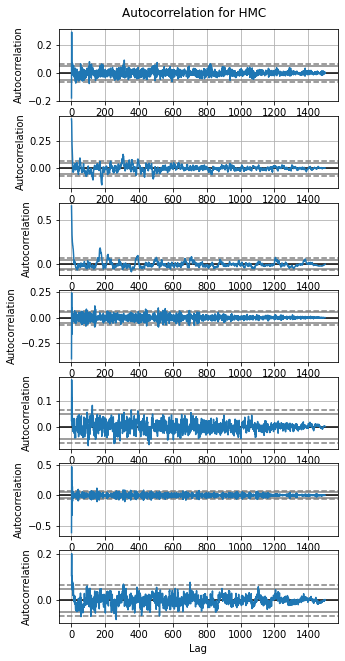

In [8]:
from scipy.stats import multivariate_normal
class GeneHMCModel():
    def __init__(self, x):
        self.x = x                  # data matrix of all four groups with
                                    # each row as a data point.
                                    # Each group is assumed to have same number of  points.
        self.n_groups = 4           # number of groups
        self.n_params = 7           # number of parameters
        self.group_size = x.shape[0] // self.n_groups
    # Slices the data matrix to the specified group number (indexed from 0).
    def __x_group(self, i):
        return self.x[i*self.group_size:(i+1)*self.group_size,:]
    # Assumes that theta = (sigma^2, lambda, tau, mu, gamma)
    def __theta_split(self, theta):
        sigma_sq = theta[0]
        lmda = theta[1]
        tau = theta[2]
        mu = theta[3:5]
        mu = np.array(mu)
        gamma = theta[5:]
        gamma = np.array(gamma)
        return (sigma_sq, lmda, tau, mu, gamma)
    # Computes the log-pdf of the model.
    def lp(self, theta):
        sigma_sq, lmda, tau, mu, gamma = self.__theta_split(theta)
        if sigma_sq < 1e-10: return np.NINF
        lp = 0
        lp += np.sum(multivariate_normal.logpdf(self.__x_group(0), mean=mu, 
cov=sigma_sq))
        lp += np.sum(multivariate_normal.logpdf(self.__x_group(1), mean=gamma, 
cov=sigma_sq))
        lp += np.sum(multivariate_normal.logpdf(self.__x_group(2), mean=(lmda*(mu-
gamma) + gamma), cov=sigma_sq))
        lp += np.sum(multivariate_normal.logpdf(self.__x_group(3), mean=(tau*(mu-
gamma) + gamma), cov=sigma_sq))
        lp += -np.log(sigma_sq) if sigma_sq > 0 else 0
        lp += 0 if lmda >= 0 and lmda <= 1 else np.NINF
        lp += 0 if tau >= 0 and tau <= 1 else np.NINF
        return lp
    # Helper functions to compute certain partial derivatives.
    def normal_dlp_dmu(self, x, mu, sigma_sq):
        if sigma_sq == 0:
            return np.array([np.Inf, np.Inf])
        else:
            return (x - mu) / sigma_sq
    def normal_dlp_dsigma_sq(self, x, mu, sigma_sq):
        diff = x-mu
        if sigma_sq == 0:
            return np.Inf
        else:
            return np.dot(diff, diff) / (2 * sigma_sq**2) - 1 / sigma_sq
    # Computes the gradient of log-pdf of the model w.r.t. theta
    def dlp(self, theta):
        sigma_sq, lmda, tau, mu, gamma = self.__theta_split(theta)
        dlp_dsigma_sq = \
            np.sum([self.normal_dlp_dsigma_sq(xi, mu, sigma_sq) for xi in 
self.__x_group(0)]) \
            + np.sum([self.normal_dlp_dsigma_sq(xi, gamma, sigma_sq) for xi in 
self.__x_group(1)]) \
            + np.sum([self.normal_dlp_dsigma_sq(xi, lmda*(mu-gamma) + gamma, 
sigma_sq) for xi in self.__x_group(2)]) \
            + np.sum([self.normal_dlp_dsigma_sq(xi, tau*(mu-gamma) + gamma, 
sigma_sq) for xi in self.__x_group(3)]) \
            + (np.NINF if sigma_sq == 0 else -1./sigma_sq)
        dlp_dlmda = \
            np.sum([self.normal_dlp_dmu(xi, lmda*(mu-gamma) + gamma, 
sigma_sq).dot(mu-gamma) for xi in self.__x_group(2)])
        dlp_dtau = \
            np.sum([self.normal_dlp_dmu(xi, tau*(mu-gamma) + gamma, 
sigma_sq).dot(mu-gamma) for xi in self.__x_group(3)])
        dlp_dmu = \
            np.array([self.normal_dlp_dmu(xi, mu, sigma_sq) for xi in 
self.__x_group(0)]).sum(axis=0) \
            + np.array([self.normal_dlp_dmu(xi, lmda*(mu-gamma) + gamma, sigma_sq) 
* lmda for xi in self.__x_group(2)]).sum(axis=0) \
            + np.array([self.normal_dlp_dmu(xi, tau*(mu-gamma) + gamma, sigma_sq) *
tau for xi in self.__x_group(3)]).sum(axis=0)
        dlp_dgamma = \
            np.array([self.normal_dlp_dmu(xi, gamma, sigma_sq) for xi in 
self.__x_group(1)]).sum(axis=0) \
            + np.array([self.normal_dlp_dmu(xi, lmda*(mu-gamma) + gamma, sigma_sq) 
* (1-lmda) for xi in self.__x_group(2)]).sum(axis=0) \
            + np.array([self.normal_dlp_dmu(xi, tau*(mu-gamma) + gamma, sigma_sq) *
(1-tau) for xi in self.__x_group(3)]).sum(axis=0)
        return np.concatenate(([dlp_dsigma_sq, dlp_dlmda, dlp_dtau], dlp_dmu, 
dlp_dgamma))
if __name__ == '__main__':
    import matplotlib.pyplot as plt

    x = np.array([
        [1.1092, 0.9592],
        [0.7942, -0.5889],
        [0.0521, -1.1212],
        [-1.0795, -1.2398],
        [2.4925, 0.4005],
        [-1.8491, 1.2854],
        [0.1581, 3.0208],
        [0.0776, 2.6427],
        [0.8305, 0.4605],
        [-1.2829, 0.9888],
        [0.191, 1.2963],
        [0.612, -0.304],
        [-0.6328, 2.2947],
        [0.7406, 1.3705],
        [1.3908, 1.7367],
        [1.3897, 2.1947]
    ])
    
    model = GeneHMCModel(x)
    #samples = hmc(model, init=np.array([1, 0.5, 0.5, 0, 0, 0, 0]))
    samples = hmc_no_reject(model, init=np.array([1, 0.5, 0.5, 0, 0, 0, 0]), 
burn_in = 0, n_samples = 1500)
    print(samples.shape)
    fig, ax = plt.subplots(samples.shape[0], 1, figsize=(5,10))
    for i in range(samples.shape[0]):
    #    ax[i].hist(samples[i,:], bins='auto')
        x = pd.plotting.autocorrelation_plot(samples[i,:], ax = ax[i])
    fig.suptitle('Autocorrelation for HMC')
    #fig.tight_layout()
    fig.subplots_adjust(top = 0.95)
    plt.show()

# **Metropolis Hasting Algorithm**

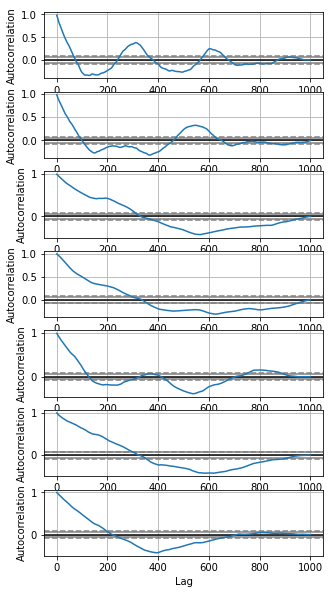

In [9]:
from scipy.stats import multivariate_normal, norm
def mh(hmc_obj, n_samples = 1000, burn_in = 500, eps = 0.1, init = None):
    theta = np.zeros(hmc_obj.n_params) if init is None else init
    samples = np.zeros((hmc_obj.n_params, n_samples+ burn_in))
    samples[:,0] = theta
    
    for i in range(1, samples.shape[1]):
        theta_new = theta + eps * np.random.normal(size = hmc_obj.n_params)
        lptheta = hmc_obj.lp(theta)
        lptheta_new = hmc_obj.lp(theta_new)
        alpha = min(1,np.exp(lptheta_new - lptheta))
        accept = (np.random.uniform() <= alpha)
        if accept:
            theta = theta_new
        samples[:,i] = theta
    return samples[:,burn_in:]

def mh_rand(hmc_obj, n_samples = 1000, burn_in = 500, delta = 0.01, eps = 0.1, init
= None):
    theta = np.zeros(hmc_obj.n_params) if init is None else init
    samples = np.zeros((hmc_obj.n_params, n_samples+ burn_in))
    samples[:,0] = theta
    
    for i in range(1, samples.shape[1]):
        step = np.random.normal(size = hmc_obj.n_params)
        pm1 = np.random.randint(0,2) * 2 - 1
        theta_new = theta + pm1 * delta * hmc_obj.dlp(theta) + eps * step
        #posterior likelihood ratio
        lptheta = hmc_obj.lp(theta)
        lptheta_new = hmc_obj.lp(theta_new)
        alpha = np.exp(lptheta_new - lptheta)
        
        #sampling ratio
        reverse_step = ((theta - theta_new) + delta * hmc_obj.dlp(theta_new))/eps
        alpha = alpha * np.prod(norm.pdf(step))/np.prod(norm.pdf(reverse_step))
        
        #sampling ratio other step
        step_alt = (eps * step + 2 * pm1 * delta * hmc_obj.dlp(theta))/eps
        reverse_step_alt = ((theta - theta_new) + delta * hmc_obj.dlp(theta_new))/eps
        alpha = alpha *np.prod(norm.pdf(step_alt))/np.prod(norm.pdf(reverse_step_alt))
        alpha = min(1, alpha)
        accept = (np.random.uniform() <= alpha)
        if accept:
            theta = theta_new
        samples[:,i] = theta
    return samples[:,burn_in:]
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    
    x = np.array([
        [1.1092, 0.9592],
        [0.7942, -0.5889],
        [0.0521, -1.1212],
        [-1.0795, -1.2398],
        [2.4925, 0.4005],
        [-1.8491, 1.2854],
        [0.1581, 3.0208],
        [0.0776, 2.6427],
        [0.8305, 0.4605],
        [-1.2829, 0.9888],
        [0.191, 1.2963],
        [0.612, -0.304],
        [-0.6328, 2.2947],
        [0.7406, 1.3705],
        [1.3908, 1.7367],
        [1.3897, 2.1947]
    ])
    
    model = GeneHMCModel(x)
    theta =  [1, 0.5, 0.5, 0, 0, 1, 1]
    samples = mh(model, init = theta,n_samples = 1000, burn_in = 0, eps = 0.01)
    #samples = mh_rand(model, init = theta, eps =0.1, delta = 0.001, n_samples = 1500, burn_in = 0)
    
    fig, ax = plt.subplots(samples.shape[0], 1, figsize=(5,10))
    for i in range(samples.shape[0]):
        # ax[i].hist(samples[i,:], bins='auto')
        x = pd.plotting.autocorrelation_plot(samples[i,:], ax = ax[i])
    plt.show()

# **Gibss Sampling**

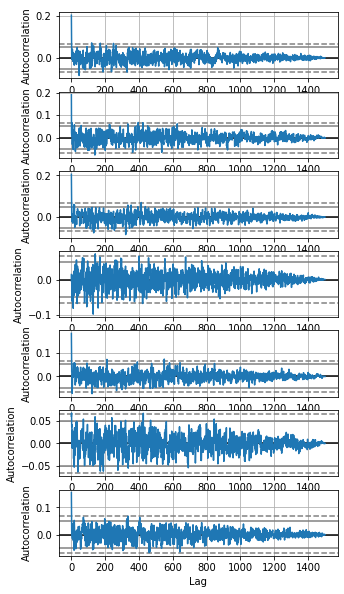

In [10]:
from scipy.stats import multivariate_normal, truncnorm
class GeneGibbsModel():
    
    def __init__(self, x):
        self.x = x                  # data matrix of all four groups with
                                    # each row as a data point.
                                    # Each group is assumed to have same number of points.
        self.n_groups = 4           # number of groups
        self.n_params = 7           # number of parameters
        self.group_size = x.shape[0] // self.n_groups
    # Slices the data matrix to the specified group number (indexed from 0).
    def __x_group(self, i):
        return self.x[i*self.group_size:(i+1)*self.group_size,:]
    # Assumes that theta = (sigma^2, lambda, tau, mu, gamma)
    def __theta_split(self, theta):
        sigma_sq = theta[0]
        lmda = theta[1]
        tau = theta[2]
        mu = theta[3:5]
        gamma = theta[5:]
        return (sigma_sq, lmda, tau, mu, gamma)
    def sum_of_squares(self, a,b):
        # for p(x) propto exp(-Ax^2 + bx), finds parameters for normal distribution
        # 1/2sigma^2 = A
        # mu/sigma^2 = b
        
        sigma_sq = 1/(2*a)
        mu = b * sigma_sq
        
        return(mu, sigma_sq)
    
    def mean_data(self, theta):
        #calculate expected value of data given theta
        #return matrix of EVs
        sigma_sq, lmda, tau, mu, gamma = self.__theta_split(theta)
        x_mean = np.zeros(self.x.shape)
        mu = np.array(mu)
        gamma = np.array(gamma)
        for i in range(self.group_size):
            x_mean[i,] = mu
            x_mean[self.n_groups+i,] = gamma
            x_mean[2*self.n_groups + i,] = lmda * mu + (1-lmda) * gamma
            x_mean[3*self.n_groups + i,] = tau * mu + (1-tau) * gamma
        return x_mean
    
    def gibbs_sigma_sq(self, theta):
        sigma_sq, lmda, tau, mu, gamma = self.__theta_split(theta)
        alpha = self.x.shape[0] + 2
        beta = np.sum((self.x - self.mean_data(theta))**2)/2
        sigma_sq_inv = np.random.gamma(shape = alpha, scale = 1/beta)
        theta[0] = 1/sigma_sq_inv
        return theta
    
    def sample_trunc_norm(self, mu, sigma_sq):
        #sample truncated 0 1 normal
        std = np.sqrt(sigma_sq)
        X = truncnorm(
            (0-mu)/ std, (1-mu)/std, loc = mu, scale = std
            )
        return X.rvs(1)[0]
    
    def gibbs_lmda_tau(self, theta):
        sigma_sq, lmda, tau, mu, gamma = self.__theta_split(theta)
        mu = np.array(mu)
        gamma = np.array(gamma)
        
        a_lmda = a_tau = self.group_size * np.sum((mu - gamma)**2)/(2* sigma_sq) + 1e-6
        
        g3 = self.__x_group(2)
        g4 = self.__x_group(3)
        
        b_lmda = b_tau = 0
        for i in range(self.group_size):
            for k in range(2):
                b_lmda += (2 * g3[i,k] * (mu[k] - gamma[k]) +
                           2 * gamma[k]**2 - 
                           2*mu[k] *gamma[k])
                b_tau += (2 * g4[i,k] * (mu[k] - gamma[k]) +
                           2 * gamma[k]**2 - 
                           2*mu[k] *gamma[k])
                
        b_lmda /= (2 * sigma_sq)
        b_tau /= (2* sigma_sq)
        
        mu_lmda, sigma_sq_lmda = self.sum_of_squares(a_lmda, b_lmda)
        mu_tau, sigma_sq_tau = self.sum_of_squares(a_tau, b_tau)
        
        lmda_new = self.sample_trunc_norm(mu_lmda, sigma_sq_lmda)
        tau_new = self.sample_trunc_norm(mu_tau, sigma_sq_tau)
        theta[1:3] = [lmda_new, tau_new]
        return theta
        
    def gibbs_means(self,theta):
        sigma_sq, lmda, tau, mu, gamma = self.__theta_split(theta)
        
        a_mu = (1+ lmda ** 2 + tau**2) * self.group_size / (2 * sigma_sq)
        a_gamma = (1 + (1-lmda)**2 + (1-tau)**2) * self.group_size / (2 * sigma_sq)
        
        b_mu_1 = b_gamma_1 = b_mu_2 = b_gamma_2 = 0
        
        g1 = self.__x_group(0)
        g2 = self.__x_group(1)
        g3 = self.__x_group(2)
        g4 = self.__x_group(3)
        
        for i in range(self.group_size):
            b_mu_1 += (g1[i,0] + g3[i,0]*lmda - lmda * (1-lmda) * gamma[0] 
                       + g4[i,0]*tau-  tau * (1-tau) * gamma[0] )/sigma_sq
            b_mu_2 += (g1[i,1] + g3[i,1]*lmda - lmda * (1-lmda) * gamma[1] 
                       + g4[i,1]*tau-  tau * (1-tau) * gamma[1] )/sigma_sq
            b_gamma_1 += (g2[i,0] + g3[i,0]*(1-lmda) - lmda * (1-lmda) * mu[0] 
                       + g4[i,0]*(1-tau)-  tau * (1-tau) * mu[0] )/sigma_sq
            b_gamma_2 += (g2[i,1] + g3[i,1]*(1-lmda) -lmda * (1-lmda) * mu[1] 
                       + g4[i,1]*(1-tau)-  tau * (1-tau) * mu[1] )/sigma_sq
            
            
        tempm, tempssq = self.sum_of_squares(a_mu, b_mu_1)    
        mu_1_new = np.random.normal(tempm, np.sqrt(tempssq))
        
        tempm, tempssq = self.sum_of_squares(a_mu, b_mu_2)    
        mu_2_new = np.random.normal(tempm, np.sqrt(tempssq))
        
        tempm, tempssq = self.sum_of_squares(a_gamma, b_gamma_1)    
        gamma_1_new = np.random.normal(tempm, np.sqrt(tempssq))
        
        tempm, tempssq = self.sum_of_squares(a_gamma, b_gamma_2)    
        gamma_2_new = np.random.normal(tempm, np.sqrt(tempssq))
        
        theta[3:] = [mu_1_new, mu_2_new, gamma_1_new, gamma_2_new]
        
        return theta
        
    def sample(self, n_samples = 1000, burn_in = 500, init = None):
        samples = np.zeros((self.n_params, n_samples + burn_in))
        theta = list(init) if init is not None and len(init) == self.n_params else list(np.zeros(self.n_params))
        
        for i in range(burn_in + n_samples):
            theta = self.gibbs_sigma_sq(theta)
            theta = self.gibbs_lmda_tau(theta)
            theta = self.gibbs_means(theta)
            samples[:,i] = theta
            
        return samples[:,burn_in:]
        
        
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    
    x = np.array([
        [1.1092, 0.9592],
        [0.7942, -0.5889],
        [0.0521, -1.1212],
        [-1.0795, -1.2398],
        [2.4925, 0.4005],
        [-1.8491, 1.2854],
        [0.1581, 3.0208],
        [0.0776, 2.6427],
        [0.8305, 0.4605],
        [-1.2829, 0.9888],
        [0.191, 1.2963],
        [0.612, -0.304],
        [-0.6328, 2.2947],
        [0.7406, 1.3705],
        [1.3908, 1.7367],
        [1.3897, 2.1947]
    ])
    
    model = GeneGibbsModel(x)
    theta =  np.array([1, 0.5, 0.5, 0, 0, 1, 1])
    samples = model.sample(init = theta, burn_in = 0, n_samples = 1500)
    
    fig, ax = plt.subplots(samples.shape[0], 1, figsize=(5,10))
    for i in range(samples.shape[0]):
    #    ax[i].hist(samples[i,:], bins='auto')
        x = pd.plotting.autocorrelation_plot(samples[i,:], ax = ax[i])
    plt.show()

# **Importance Sampling**

Please not there is an error for this algorithm that I did not have time to fix

In [11]:
# Calculate the posterior density given data
from tqdm import tqdm
df_np=pd.read_csv("/content/drive/MyDrive/bayesian stats/data.csv")

# Calculate the posterior density given data
from scipy.stats import multivariate_normal

def negative_log_prob(theta):
  prob=np.log(theta[0]) # prior
  for row in df_np:
    if row[0] == 1:
      prob -= multivariate_normal.logpdf(row[1], theta[3], np.sqrt(theta[0]))
      prob -= multivariate_normal.logpdf(row[2], theta[4], np.sqrt(theta[0]))
    if row[0] == 2:
      prob -=multivariate_normal.logpdf(row[1], theta[5], np.sqrt(theta[0]))
      prob -= multivariate_normal.logpdf(row[2], theta[6], np.sqrt(theta[0]))
    if row[0] ==3:
      prob -= multivariate_normal.logpdf(row[1], theta[1]*theta[3] + (1-theta[1])*theta[5], np.sqrt(theta[0]))
      prob -= multivariate_normal.logpdf(row[2], theta[1]*theta[4] + (1-theta[1])*theta[6], np.sqrt(theta[0]))
    if row[0] ==4:
      prob -=multivariate_normal.logpdf(row[1], theta[2]*theta[3] + (1-theta[2])*theta[5], np.sqrt(theta[0]))
      prob -=multivariate_normal.logpdf(row[2], theta[2]*theta[4] + (1-theta[2])*theta[6], np.sqrt(theta[0]))
    return prob

def pdf(theta):
  return np.exp(-negative_log_prob(theta))

# sample from truncated prior
var_min=0.01
var_max=10
mean_max=10

def sample_truncated(size):
  r=np.random.uniform(0, 1, size=(1, size))
  var= var_min * np.power(var_max / var_min, r) # inverse transform
  mix =np.random.uniform(0,1, size=(2, size))
  mean =np.random.uniform(-mean_max, mean_max, size=(4, size))
  probs = 1/var # the density for this smpl will be 1/var. we are using normalization so thats fine if no constant here
  return np.concatenate((var, mix, mean)).T, probs.reshape(-1).T # we are returining sample and the probability of each of the sample
theta_params=["var", "lambda", "tau", "mu1", "mu2", "gamma1", "gamma2"]
def Importance_Sampling(num_iter):
  rows, probs=sample_truncated(num_iter)
  avg_row=np.zeros(7)
  prob_sum=0  #  the cummulative weights
  for row, prob in tqdm(zip(rows, probs)):
    avg_row +=pdf(row)/prob*row # the density of the posterior over the density of prior
    prob_sum += pdf(row)/probs
    return avg_row /prob_sum #  this is a version of importance sampling when you dont know normalizeing const

theta_mean = Importance_Sampling(7) # now I have my mean and can print out all the different values
print("theta_mean:")
for key, value in zip(theta_params, list(theta_mean)):
  print(f" {key}={value:.4f}")

samples = Importance_Sampling(7)
fig, ax = plt.subplots(samples.shape[0], 1, figsize=(5,10))
for i in range(samples.shape[0]):
  # ax[i].hist(samples[i,:], bins='auto')
  x = pd.plotting.autocorrelation_plot(samples[i,:], ax = ax[i])
  plt.show()

# **Wrapping all Together**

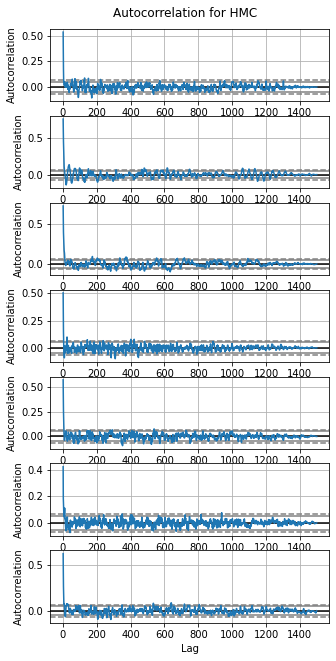

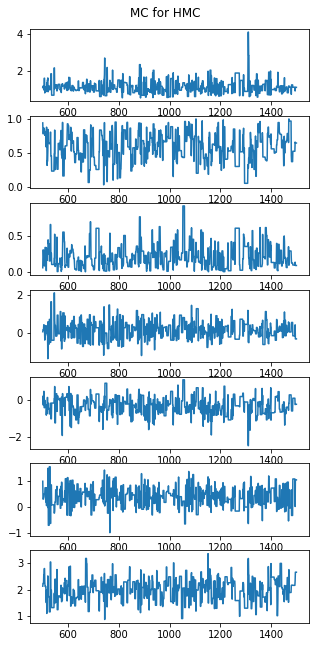

L2 error for HMC: 0.8943647417169998


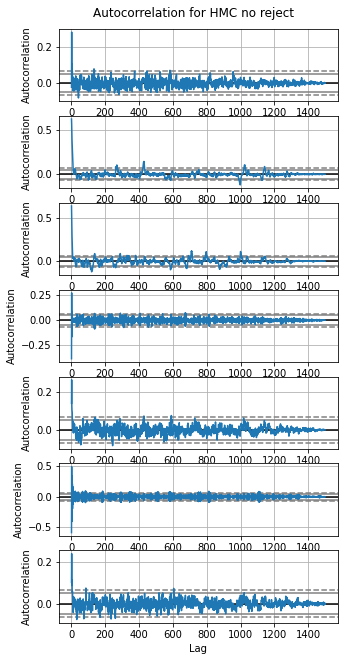

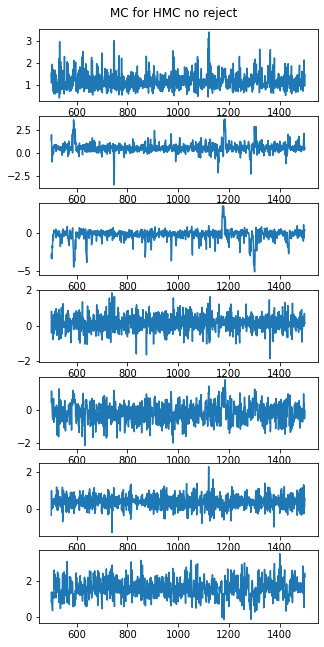

L2 error for HMC no reject: 1.2705497432628854


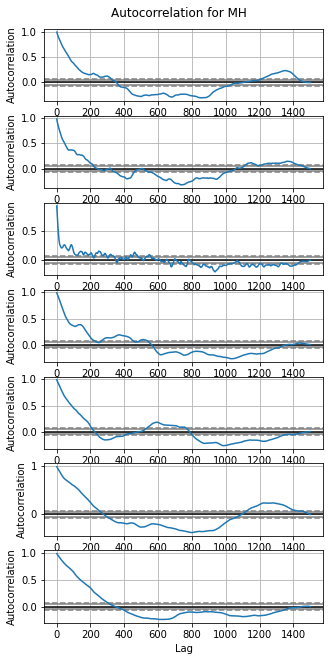

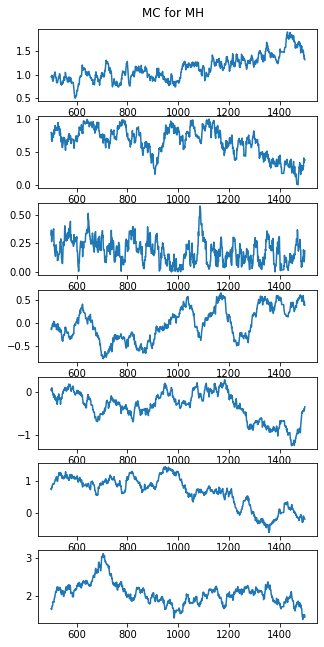

L2 error for MH: 0.7706418239083388


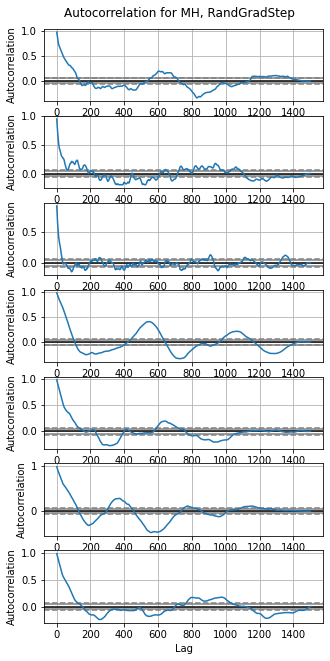

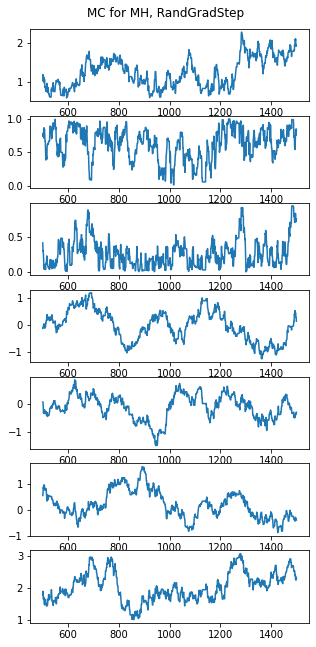

L2 error for MH, RandGradStep: 0.9707982244059643


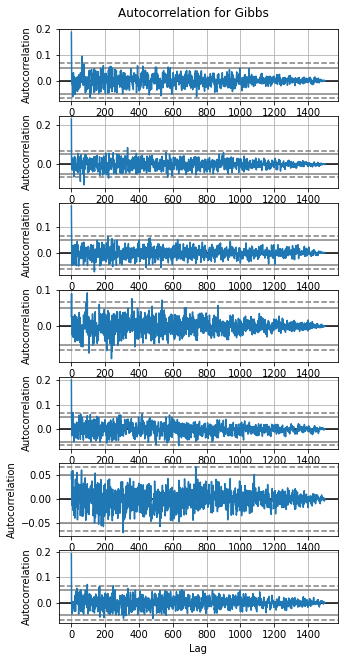

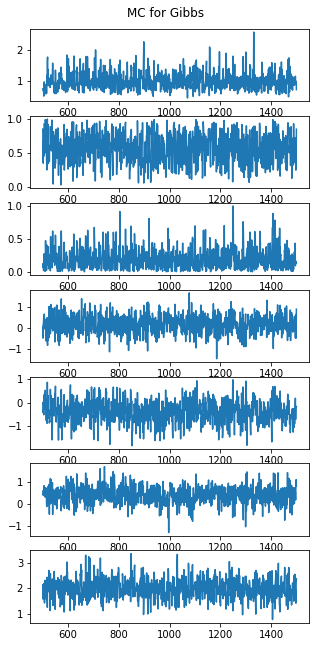

L2 error for Gibbs: 0.8927093137480498


In [12]:
import matplotlib.pyplot as plt
def wrapper(samples, truth, title = '', burn_in = 500):
    fig, ax = plt.subplots(samples.shape[0], 1, figsize=(5,10))
    for i in range(samples.shape[0]):
        x = pd.plotting.autocorrelation_plot(samples[i,:], ax = ax[i])
    fig.suptitle('Autocorrelation for ' + title)
    #fig.tight_layout()
    fig.subplots_adjust(top = 0.95)
    plt.show()
    
    
    fig, ax = plt.subplots(samples.shape[0], 1, figsize=(5,10))
    for i in range(samples.shape[0]):
        ax[i].plot(range(burn_in,samples.shape[1]),samples[i,burn_in:])
    fig.suptitle('MC for ' + title)
    #fig.tight_layout()
    fig.subplots_adjust(top = 0.95)
    plt.show()
    
    print('L2 error for ' + title + ': ' + str(error_samples(samples, truth, 
burn_in)))
    
def error_samples(samples, truth, burn_in = 500):
    emp_mean = np.mean(samples[:, burn_in:], axis = 1)
    return np.linalg.norm(emp_mean - truth)
if __name__ == '__main__':
    truth = np.array([1,1/3,2/3,0,0,1,2])
    init = np.array([1,0.5,0.5,0,0,0,0])
    
    x = np.array([
        [1.1092, 0.9592],
        [0.7942, -0.5889],
        [0.0521, -1.1212],
        [-1.0795, -1.2398],
        [2.4925, 0.4005],
        [-1.8491, 1.2854],
        [0.1581, 3.0208],
        [0.0776, 2.6427],
        [0.8305, 0.4605],
        [-1.2829, 0.9888],
        [0.191, 1.2963],
        [0.612, -0.304],
        [-0.6328, 2.2947],
        [0.7406, 1.3705],
        [1.3908, 1.7367],
        [1.3897, 2.1947]
    ])
    
    model = GeneHMCModel(x)
    samples = hmc(model, init=init, burn_in = 0, n_samples = 1500)
    wrapper(samples, truth, title = 'HMC')
    
    samples = hmc_no_reject(model, init=init, burn_in = 0, n_samples = 1500)
    wrapper(samples, truth, title = 'HMC no reject')
    
    samples = mh(model, init = init,n_samples = 1500, burn_in = 0, eps = 0.05)
    wrapper(samples, truth, title = 'MH')
        
    samples = mh_rand(model, init = init, eps =0.1, delta = 0.001, n_samples = 1500, burn_in = 0)
    wrapper(samples, truth, title = 'MH, RandGradStep')
    
    model = GeneGibbsModel(x)
    samples = model.sample(init = init, burn_in = 0, n_samples = 1500)
    wrapper(samples, truth, title = 'Gibbs')